In [1]:
# pip uninstall numpy

In [2]:
# pip install numpy==1.26.4

In [3]:
yolo='yolov8l'

In [4]:
import os
import cv2
import yaml
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Deep learning and YOLO imports
from ultralytics import YOLO
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline


In [6]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.7.1+cu118
CUDA available: True
Number of GPUs: 1


In [7]:
class DatasetAnalyzer:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.classes = []
        self.class_counts = Counter()
        self.image_info = []
        self.annotation_info = []
        
    def load_dataset_config(self):
        """Load dataset configuration from data.yaml"""
        yaml_path = self.dataset_path / 'data.yaml'
        if yaml_path.exists():
            with open(yaml_path, 'r') as f:
                self.config = yaml.safe_load(f)
            self.classes = self.config.get('names', [])
            print(f"Dataset classes: {self.classes}")
            return True
        else:
            print("No data.yaml found. Please ensure your dataset follows YOLO format.")
            return False
    
    def analyze_images(self, split='train'):
        """Analyze images in the dataset"""
        images_path = self.dataset_path / split / 'images'
        labels_path = self.dataset_path / split / 'labels'
        
        if not images_path.exists():
            print(f"Images path not found: {images_path}")
            return
            
        image_files = list(images_path.glob('*'))
        print(f"Found {len(image_files)} images in {split} split")
        
        for img_file in image_files[:]:  # Analyze first 100 images for speed
            try:
                # Load image
                img = cv2.imread(str(img_file))
                if img is None:
                    continue
                    
                h, w, c = img.shape
                
                # Load corresponding label
                label_file = labels_path / f"{img_file.stem}.txt"
                bbox_count = 0
                class_ids = []
                
                if label_file.exists():
                    with open(label_file, 'r') as f:
                        lines = f.readlines()
                        bbox_count = len(lines)
                        for line in lines:
                            parts = line.strip().split()
                            if parts:
                                class_id = int(parts[0])
                                class_ids.append(class_id)
                                self.class_counts[class_id] += 1
                
                self.image_info.append({
                    'filename': img_file.name,
                    'width': w,
                    'height': h,
                    'channels': c,
                    'aspect_ratio': w/h,
                    'area': w*h,
                    'bbox_count': bbox_count,
                    'classes': class_ids
                })
                
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
    
    def create_analysis_report(self):
        """Create comprehensive analysis report"""
        df = pd.DataFrame(self.image_info)
        
        print("=== DATASET ANALYSIS REPORT ===\n")
        
        # Basic statistics
        print("📊 Dataset Statistics:")
        print(f"Total images analyzed: {len(df)}")
        print(f"Total classes: {len(self.classes)}")
        print(f"Total bounding boxes: {sum(self.class_counts.values())}")
        
        # Image dimensions
        print(f"\n📐 Image Dimensions:")
        print(f"Width - Mean: {df['width'].mean():.1f}, Std: {df['width'].std():.1f}")
        print(f"Height - Mean: {df['height'].mean():.1f}, Std: {df['height'].std():.1f}")
        print(f"Aspect Ratio - Mean: {df['aspect_ratio'].mean():.2f}, Std: {df['aspect_ratio'].std():.2f}")
        
        # Class distribution
        print(f"\n🏷️ Class Distribution:")
        for class_id, count in self.class_counts.most_common():
            class_name = self.classes[class_id] if class_id < len(self.classes) else f"Class_{class_id}"
            percentage = (count / sum(self.class_counts.values())) * 100
            print(f"{class_name}: {count} instances ({percentage:.1f}%)")
        
        return df
    
    def visualize_analysis(self, df):
        """Create visualizations for dataset analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Dataset Analysis Visualizations', fontsize=16, fontweight='bold')
        
        # Image dimensions distribution
        axes[0, 0].hist(df['width'], bins=30, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Image Width Distribution')
        axes[0, 0].set_xlabel('Width (pixels)')
        axes[0, 0].set_ylabel('Frequency')
        
        axes[0, 1].hist(df['height'], bins=30, alpha=0.7, color='lightgreen')
        axes[0, 1].set_title('Image Height Distribution')
        axes[0, 1].set_xlabel('Height (pixels)')
        axes[0, 1].set_ylabel('Frequency')
        
        # Aspect ratio distribution
        axes[0, 2].hist(df['aspect_ratio'], bins=30, alpha=0.7, color='salmon')
        axes[0, 2].set_title('Aspect Ratio Distribution')
        axes[0, 2].set_xlabel('Width/Height Ratio')
        axes[0, 2].set_ylabel('Frequency')
        
        # Bounding boxes per image
        axes[1, 0].hist(df['bbox_count'], bins=range(0, df['bbox_count'].max()+2), 
                       alpha=0.7, color='gold')
        axes[1, 0].set_title('Bounding Boxes per Image')
        axes[1, 0].set_xlabel('Number of Bounding Boxes')
        axes[1, 0].set_ylabel('Frequency')
        
        # Class distribution
        if self.class_counts:
            class_names = [self.classes[i] if i < len(self.classes) else f"Class_{i}" 
                          for i in self.class_counts.keys()]
            counts = list(self.class_counts.values())
            
            axes[1, 1].bar(class_names, counts, color='purple', alpha=0.7)
            axes[1, 1].set_title('Class Distribution')
            axes[1, 1].set_xlabel('Classes')
            axes[1, 1].set_ylabel('Number of Instances')
            axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Image area distribution
        axes[1, 2].scatter(df['width'], df['height'], alpha=0.6, color='red')
        axes[1, 2].set_title('Image Dimensions Scatter')
        axes[1, 2].set_xlabel('Width (pixels)')
        axes[1, 2].set_ylabel('Height (pixels)')
        
        plt.tight_layout()
        plt.show()

In [8]:
# Initialize dataset analyzer
dataset_path = "..//data//detection"  # Update this path
analyzer = DatasetAnalyzer(dataset_path)

Dataset classes: ['Platelets', 'RBC', 'WBC']
Found 1224 images in train split
Error processing ..\data\detection\train\images\BloodImage_00001_jpg.rf.18198f1b117dd5260b06c1a94ecadf39.npy: 'NoneType' object has no attribute 'ndim'
Error processing ..\data\detection\train\images\BloodImage_00001_jpg.rf.1c15f2b6cf90ca77d47aca80793c3b67.npy: 'NoneType' object has no attribute 'ndim'
Error processing ..\data\detection\train\images\BloodImage_00001_jpg.rf.e8d4e249d49f807ccd1751f485d0d960.npy: 'NoneType' object has no attribute 'ndim'
Error processing ..\data\detection\train\images\BloodImage_00002_jpg.rf.0b28b1ca873f9a33f74123e1a21dc603.npy: 'NoneType' object has no attribute 'ndim'
Error processing ..\data\detection\train\images\BloodImage_00002_jpg.rf.8aff9b9f1c9f746fad42c6057ad44271.npy: 'NoneType' object has no attribute 'ndim'
Error processing ..\data\detection\train\images\BloodImage_00002_jpg.rf.9b5c602a35149bdbb4ce169ac477e3e4.npy: 'NoneType' object has no attribute 'ndim'
Error proc

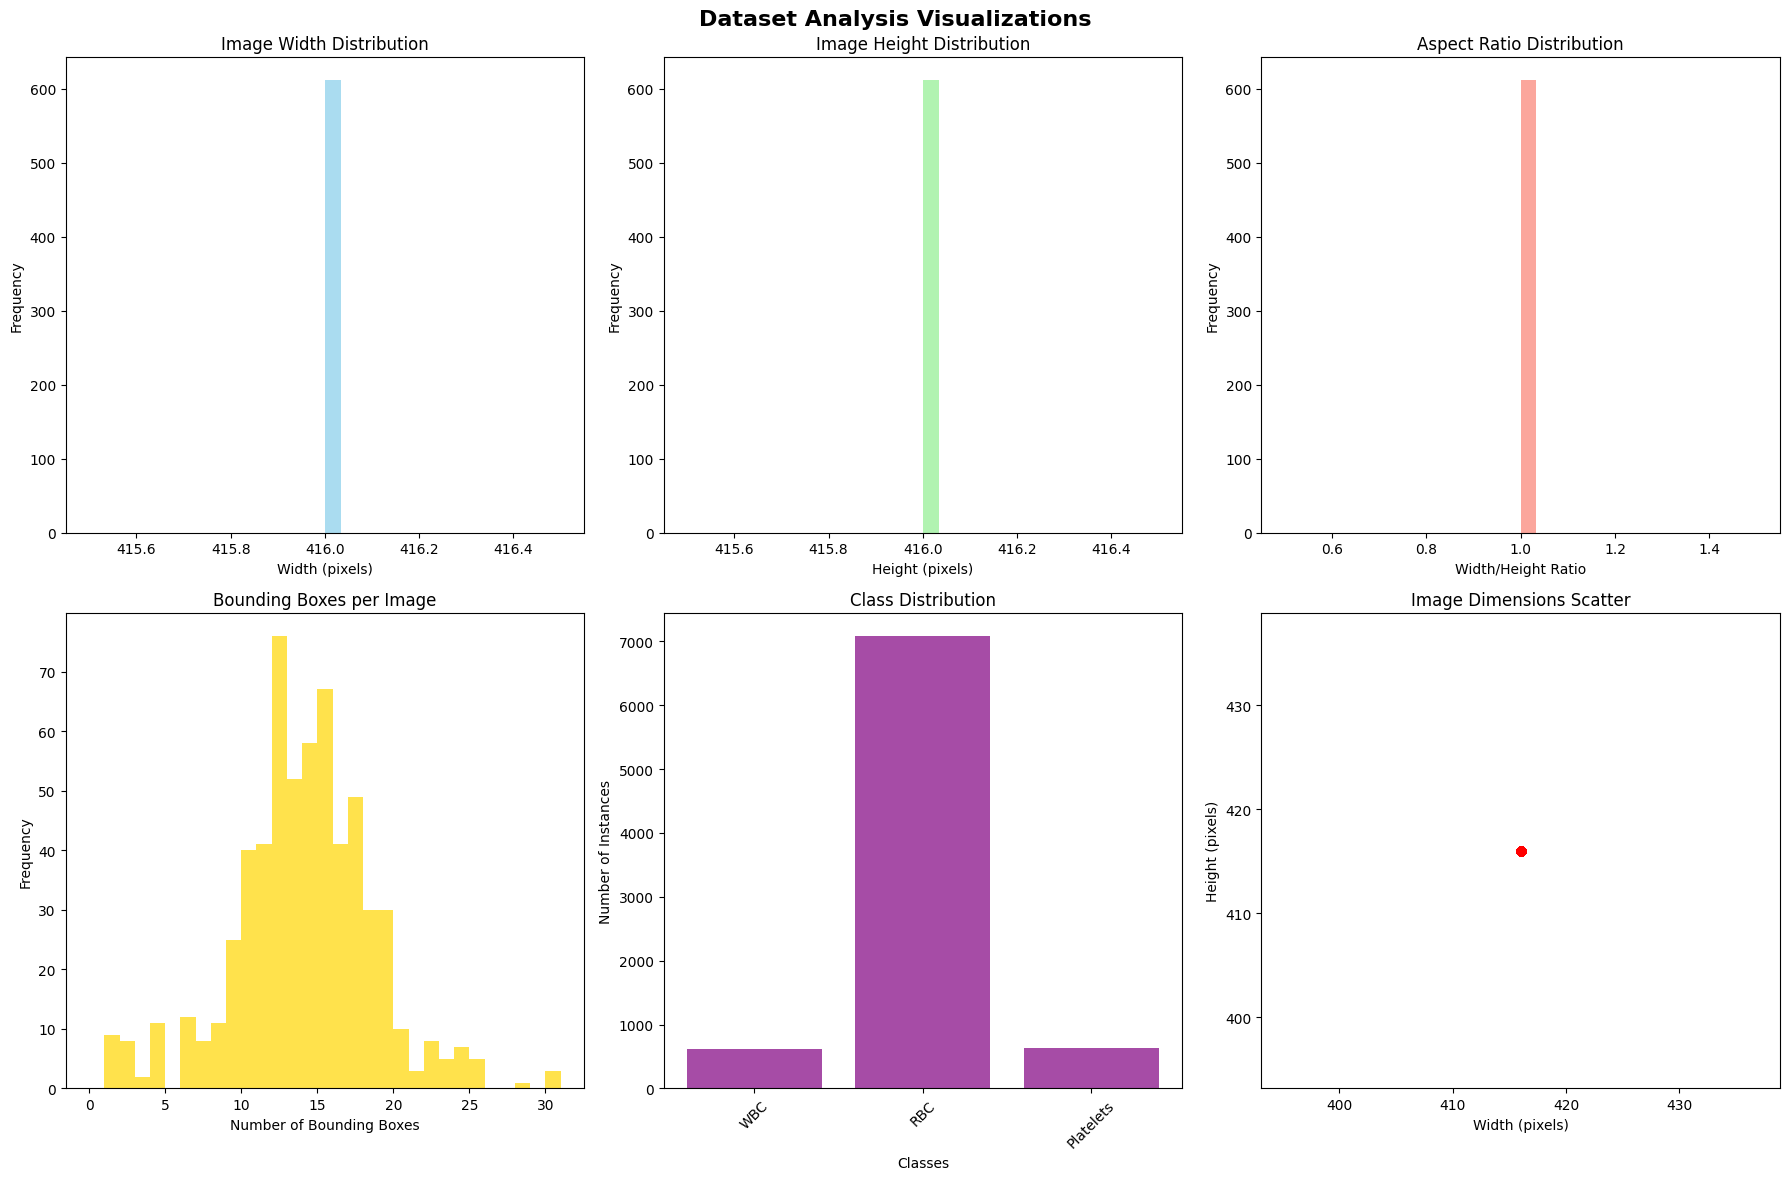

In [9]:
# Load configuration and analyze data
if analyzer.load_dataset_config():
    analyzer.analyze_images('train')
    df_analysis = analyzer.create_analysis_report()
    analyzer.visualize_analysis(df_analysis)

In [10]:
def create_augmented_config(base_config_path, output_path):
    """Create configuration with data augmentation parameters"""
    
    augmentation_config = {
        # Spatial augmentations
        'flipud': 0.5,      # Vertical flip probability
        'fliplr': 0.5,      # Horizontal flip probability  
        'degrees': 10.0,    # Rotation degrees
        'translate': 0.1,   # Translation fraction
        'scale': 0.2,       # Scale factor
        'shear': 2.0,       # Shear degrees
        'perspective': 0.0, # Perspective distortion
        
        # Color augmentations
        'hsv_h': 0.015,     # HSV Hue gain
        'hsv_s': 0.7,       # HSV Saturation gain  
        'hsv_v': 0.4,       # HSV Value gain
        
        # Mosaic and mixup
        'mosaic': 1.0,      # Mosaic probability
        'mixup': 0.1,       # Mixup probability
        'copy_paste': 0.1,  # Copy-paste probability
    }
    
    # Save augmentation config
    with open(output_path, 'w') as f:
        yaml.dump(augmentation_config, f)
    
    print("Augmentation configuration saved!")
    return augmentation_config

In [11]:
# Create augmentation configuration
aug_config = create_augmented_config("../data/detection/data.yaml", "../data/detection/augmentation_config.yaml")

Augmentation configuration saved!


In [12]:
class YOLOTrainer:
    def __init__(self, model_size='n', dataset_path=None):
        """
        Initialize YOLO trainer
        Args:
            model_size: 'n' (nano), 's' (small), 'm' (medium), 'l' (large), 'x' (xlarge)
            dataset_path: Path to dataset configuration
        """
        self.model_size = model_size
        self.dataset_path = dataset_path
        self.model = None
        self.results = None
        
    def initialize_model(self, pretrained=True):
        """Initialize YOLO model and print layer structure"""
        model_name = f'yolov8{self.model_size}.pt' if pretrained else f'yolov8{self.model_size}.yaml'
        self.model = YOLO(model_name)
        print(f"✅ Initialized YOLOv8{self.model_size} model")

        # Print model layers
        self.print_model_layers()

    def print_model_layers(self):
        """Print and count YOLO model layers"""
        if self.model is None:
            print("⚠️ Model is not initialized.")
            return

        try:
            layers = list(self.model.model.model)  # Access the nn.Sequential block
            print("\n📦 Model Layers:")
            for i, layer in enumerate(layers):
                print(f"Layer {i}: {layer.__class__.__name__} -> {layer}")
            print(f"\n🔢 Total Layers: {len(layers)}\n")
        except Exception as e:
            print(f"❌ Could not print layers: {e}")

        
    def train_model(self, epochs=100, imgsz=640, batch_size=16, device='auto'):
        """Train the YOLO model with advanced parameters"""
        
        training_args = {
            'data': self.dataset_path,
            'epochs': epochs,
            'imgsz': imgsz,
            'batch': batch_size,
            'device': device,
            
            # Optimization parameters
            'optimizer': 'AdamW',  # SGD, Adam, AdamW
            'lr0': 0.01,          # Initial learning rate
            'lrf': 0.01,          # Final learning rate fraction
            'momentum': 0.937,     # SGD momentum
            'weight_decay': 0.0005, # L2 regularization
            'warmup_epochs': 3,    # Warmup epochs
            'warmup_momentum': 0.8, # Warmup initial momentum
            'warmup_bias_lr': 0.1, # Warmup initial bias learning rate
            
            # Data augmentation (can override config file)
            'flipud': 0.5,
            'fliplr': 0.5,
            'degrees': 10.0,
            'translate': 0.1,
            'scale': 0.2,
            'shear': 2.0,
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'mosaic': 1.0,
            'mixup': 0.1,
            
            # Training settings
            'patience': 20,        # Early stopping patience
            'save': True,          # Save checkpoints
            'save_period': 10,     # Save every N epochs
            'cache': 'disk',        # Cache images in RAM/disk
            'workers': 8,          # Number of worker threads
            'project': 'yolo_experiments',
            'name': f'yolov8{self.model_size}_training',
            'exist_ok': True,
            
            # Validation settings
            'val': True,
            'split': 'val',
            'rect': False,         # Rectangular training
            'resume': False,       # Resume training
            'amp': True,          # Automatic Mixed Precision
            'fraction': 1.0,      # Dataset fraction to use
            'profile': False,     # Profile ONNX and TensorRT speeds
            'freeze': 0,       # Freeze layers: backbone=10, all=24
            'multi_scale': False, # Multi-scale training
            'overlap_mask': True, # Overlap masks
            'mask_ratio': 4,      # Mask downsample ratio
            'dropout': 0.0,       # Use dropout regularization
        }
        
        print("🚀 Starting model training...")
        print(f"Training configuration: {training_args}")
        
        try:
            self.results = self.model.train(**training_args)
            print("✅ Training completed successfully!")
            return self.results
        except Exception as e:
            print(f"❌ Training failed: {e}")
            return None
    
    def validate_model(self, data_path=None, split='val'):
        """Validate the trained model"""
        if self.model is None:
            print("Model not initialized or trained!")
            return None
            
        print("📊 Running model validation...")
        
        validation_args = {
            'data': data_path or self.dataset_path,
            'split': split,
            'imgsz': 640,
            'batch': 1,
            'conf': 0.25,
            'iou': 0.6,
            'max_det': 300,
            'half': False,
            'device': None,
            'dnn': False,
            'plots': True,
            'rect': False,
            'save_json': True,
            'save_hybrid': False,
            'verbose': True,
        }
        
        val_results = self.model.val(**validation_args)
        return val_results

In [13]:
trainer = YOLOTrainer(model_size=yolo[-1], dataset_path='../data/detection/data.yaml')  # Update path
trainer.initialize_model(pretrained=True)

✅ Initialized YOLOv8l model

📦 Model Layers:
Layer 0: Conv -> Conv(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)
Layer 1: Conv -> Conv(
  (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)
Layer 2: C2f -> C2f(
  (cv1): Conv(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0-2): 3 x Bottl

In [14]:
results = trainer.train_model(
    epochs=100,
    imgsz=640,
    batch_size=16,
    device='cuda'  # Will use GPU if available
)

🚀 Starting model training...
Training configuration: {'data': '../data/detection/data.yaml', 'epochs': 100, 'imgsz': 640, 'batch': 16, 'device': 'cuda', 'optimizer': 'AdamW', 'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'flipud': 0.5, 'fliplr': 0.5, 'degrees': 10.0, 'translate': 0.1, 'scale': 0.2, 'shear': 2.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'mosaic': 1.0, 'mixup': 0.1, 'patience': 20, 'save': True, 'save_period': 10, 'cache': 'disk', 'workers': 8, 'project': 'yolo_experiments', 'name': 'yolov8l_training', 'exist_ok': True, 'val': True, 'split': 'val', 'rect': False, 'resume': False, 'amp': True, 'fraction': 1.0, 'profile': False, 'freeze': 0, 'multi_scale': False, 'overlap_mask': True, 'mask_ratio': 4, 'dropout': 0.0}
New https://pypi.org/project/ultralytics/8.3.156 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.152  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVID

train: Scanning C:\YOLOv8-Medical-Imaging\data\detection\train\labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]
train: Caching images (0.3GB Disk): 100%|██████████| 612/612 [00:00<00:00, 19674.81it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 13.25.9 MB/s, size: 11.7 KB)


val: Scanning C:\YOLOv8-Medical-Imaging\data\detection\valid\labels.cache... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]
val: Caching images (0.1GB Disk): 100%|██████████| 175/175 [00:00<00:00, 10025.31it/s]


Plotting labels to yolo_experiments\yolov8l_training\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_experiments\yolov8l_training
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.98G      2.146       3.93       2.39        332        640:   5%|▌         | 2/39 [00:45<13:57, 22.62s/it]


KeyboardInterrupt: 

In [36]:
trainer.validate_model()

📊 Running model validation...
WARNING 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.152  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 25.013.0 MB/s, size: 12.5 KB)


val: Scanning C:\YOLOv8-Medical-Imaging\data\detection\valid\labels.cache... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]
val: Caching images (0.1GB Disk): 100%|██████████| 175/175 [00:00<00:00, 21664.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:06<00:00, 25.95it/s]


                   all        175       2304      0.794       0.85      0.863      0.534
             Platelets         94        173      0.854      0.809       0.85      0.435
                   RBC        164       1950      0.672      0.764      0.765      0.495
                   WBC        174        181      0.857      0.978      0.975       0.67
Speed: 0.6ms preprocess, 26.6ms inference, 0.0ms loss, 2.8ms postprocess per image
Saving yolo_experiments\yolov8l_training\predictions.json...
Results saved to yolo_experiments\yolov8l_training


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001601BD38910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [37]:
class ModelEvaluator:
    def __init__(self, model_path, dataset_path):
        self.model = YOLO(model_path)
        self.dataset_path = dataset_path
        self.metrics = {}
        
    def comprehensive_evaluation(self):
        """Perform comprehensive model evaluation"""
        
        # Validate on test set
        print("📈 Evaluating model performance...")
        val_results = self.model.val(
            data=self.dataset_path,
            split='val',  # or 'val' if no test split
            imgsz=640,
            conf=0.25,
            iou=0.6,
            plots=True,
            save_json=True
        )
        
        # Extract key metrics
        self.metrics = {
            'mAP50': val_results.box.map50,
            'mAP50-95': val_results.box.map,
            'precision': val_results.box.mp,
            'recall': val_results.box.mr,
            'f1_score': 2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr),
        }
        
        return val_results
    
    def plot_training_curves(self, results_path):
        """Plot training curves from results"""
        results_df = pd.read_csv(f"{results_path}/results.csv")
        # Or if you want to group by epoch and take mean (in case of slight variations)
        results_df = results_df.groupby('epoch').first().reset_index()
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training Progress', fontsize=16, fontweight='bold')
        
        # Loss curves
        epochs = results_df['epoch']
        
        axes[0, 0].plot(epochs, results_df['train/box_loss'], label='Train Box Loss', color='#1f77b4', linewidth=2)
        axes[0, 0].plot(epochs, results_df['val/box_loss'], label='Val Box Loss', color='#ff7f0e', linewidth=2)
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        axes[0, 1].plot(epochs, results_df['train/cls_loss'], label='Train Class Loss', color='#2ca02c', linewidth=2)
        axes[0, 1].plot(epochs, results_df['val/cls_loss'], label='Val Class Loss', color='#d62728', linewidth=2)
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Metrics curves
        axes[1, 0].plot(epochs, results_df['metrics/mAP50(B)'], label='mAP@0.5', color='#ff7f0e', linewidth=2)
        axes[1, 0].plot(epochs, results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='#2ca02c', linewidth=2)
        axes[1, 0].set_title('Mean Average Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        axes[1, 1].plot(epochs, results_df['metrics/precision(B)'], label='Precision', color='#9467bd', linewidth=2)
        axes[1, 1].plot(epochs, results_df['metrics/recall(B)'], label='Recall', color='#8c564b', linewidth=2)
        axes[1, 1].set_title('Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # Debug information
        print("Train box loss sample:", results_df['train/box_loss'].head())
        print("Val box loss sample:", results_df['val/box_loss'].head())
        print("Are they equal?", results_df['train/box_loss'].equals(results_df['val/box_loss']))
        
        plt.tight_layout()
        plt.show()
    
    def confusion_matrix_analysis(self, val_results):
        """Analyze confusion matrix"""
        if hasattr(val_results, 'confusion_matrix') and val_results.confusion_matrix is not None:
            cm = val_results.confusion_matrix.matrix
            
            # Check if confusion matrix is available
            if cm is None:
                print("⚠️ Confusion matrix not available in validation results")
                return
            
            # Convert to numpy array and handle data type
            cm_array = np.array(cm)
            
            plt.figure(figsize=(10, 8))
            
            # Use appropriate format based on data type
            if cm_array.dtype.kind in 'fc':  # float or complex
                # For float values, use .1f format (1 decimal place)
                sns.heatmap(cm_array, annot=True, fmt='.1f', cmap='Blues', 
                           square=True, cbar_kws={'shrink': 0.8})
            else:
                # For integer values, use d format
                sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', 
                           square=True, cbar_kws={'shrink': 0.8})
            
            plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
            plt.xlabel('Predicted', fontsize=12)
            plt.ylabel('Actual', fontsize=12)
            
            # Add class names if available
            if hasattr(val_results, 'names') and val_results.names:
                class_names = list(val_results.names.values())
                plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
                plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
            
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Confusion matrix not available. Make sure to run validation with confusion_matrix=True")
    
    def class_wise_performance(self, val_results):
        """Analyze per-class performance"""
        try:
            # Get class names
            if hasattr(val_results, 'names') and val_results.names:
                class_names = [val_results.names[i] for i in range(len(val_results.names))]
            else:
                class_names = [f'Class_{i}' for i in range(len(val_results.box.ap))]
            
            # Create class metrics dataframe
            class_metrics = pd.DataFrame({
                'Class': class_names,
                'AP@0.5': val_results.box.ap50 if hasattr(val_results.box, 'ap50') else val_results.box.ap,
                'AP@0.5:0.95': val_results.box.ap,
                'Precision': val_results.box.p,
                'Recall': val_results.box.r
            })
            
            print("📊 Per-Class Performance:")
            print(class_metrics.round(3))
            
            # Visualize class performance
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Plot AP metrics
            x_pos = np.arange(len(class_names))
            width = 0.35
            
            axes[0].bar(x_pos - width/2, class_metrics['AP@0.5'], width, 
                       label='AP@0.5', color='#1f77b4', alpha=0.8)
            axes[0].bar(x_pos + width/2, class_metrics['AP@0.5:0.95'], width, 
                       label='AP@0.5:0.95', color='#ff7f0e', alpha=0.8)
            axes[0].set_title('Average Precision by Class', fontsize=12, fontweight='bold')
            axes[0].set_ylabel('AP Score')
            axes[0].set_xlabel('Class')
            axes[0].set_xticks(x_pos)
            axes[0].set_xticklabels(class_names, rotation=45, ha='right')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot Precision & Recall
            axes[1].bar(x_pos - width/2, class_metrics['Precision'], width, 
                       label='Precision', color='#2ca02c', alpha=0.8)
            axes[1].bar(x_pos + width/2, class_metrics['Recall'], width, 
                       label='Recall', color='#d62728', alpha=0.8)
            axes[1].set_title('Precision & Recall by Class', fontsize=12, fontweight='bold')
            axes[1].set_ylabel('Score')
            axes[1].set_xlabel('Class')
            axes[1].set_xticks(x_pos)
            axes[1].set_xticklabels(class_names, rotation=45, ha='right')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            return class_metrics
            
        except Exception as e:
            print(f"❌ Error in class-wise performance analysis: {str(e)}")
            print("This might be due to missing attributes in validation results.")
            return None
    
    def generate_evaluation_report(self, val_results, save_path=None):
        """Generate a comprehensive evaluation report"""
        report = []
        report.append("=" * 60)
        report.append("MODEL EVALUATION REPORT")
        report.append("=" * 60)
        report.append("")
        
        # Overall metrics
        report.append("📊 Overall Performance Metrics:")
        report.append("-" * 30)
        for metric, value in self.metrics.items():
            if value is not None:
                report.append(f"{metric:15}: {value:.4f}")
        report.append("")
        
        # Class-wise performance
        class_metrics = self.class_wise_performance(val_results)
        if class_metrics is not None:
            report.append("📈 Class-wise Performance Summary:")
            report.append("-" * 35)
            report.append(class_metrics.to_string(index=False, float_format='%.3f'))
            report.append("")
        
        # Print report
        report_text = "\n".join(report)
        print(report_text)
        
        # Save report if path provided
        if save_path:
            with open(save_path, 'w') as f:
                f.write(report_text)
            print(f"📄 Report saved to: {save_path}")
        
        return report_text

In [ ]:
# Evaluate the trained model
evaluator = ModelEvaluator(f'yolo_experiments/{yolo}_training/weights/best.pt', '../data/detection/data.yaml')
eval_results = evaluator.comprehensive_evaluation()

📈 Evaluating model performance...
Ultralytics 8.3.152  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 86.292.5 MB/s, size: 12.2 KB)


val: Scanning C:\YOLOv8-Medical-Imaging\data\detection\valid\labels.cache... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


                   all        175       2304      0.823      0.865      0.887      0.556
             Platelets         94        173      0.864      0.843      0.882      0.463
                   RBC        164       1950      0.727      0.775      0.801      0.521
                   WBC        174        181      0.877      0.978      0.977      0.683
Speed: 1.2ms preprocess, 24.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Saving runs\detect\val3\predictions.json...
Results saved to runs\detect\val3


Train box loss sample: 0    1.76353
1    1.50615
2    1.48585
3    1.47965
4    1.43729
Name: train/box_loss, dtype: float64
Val box loss sample: 0    1.59857
1    1.52093
2    1.46304
3    1.43331
4    1.38908
Name: val/box_loss, dtype: float64
Are they equal? False


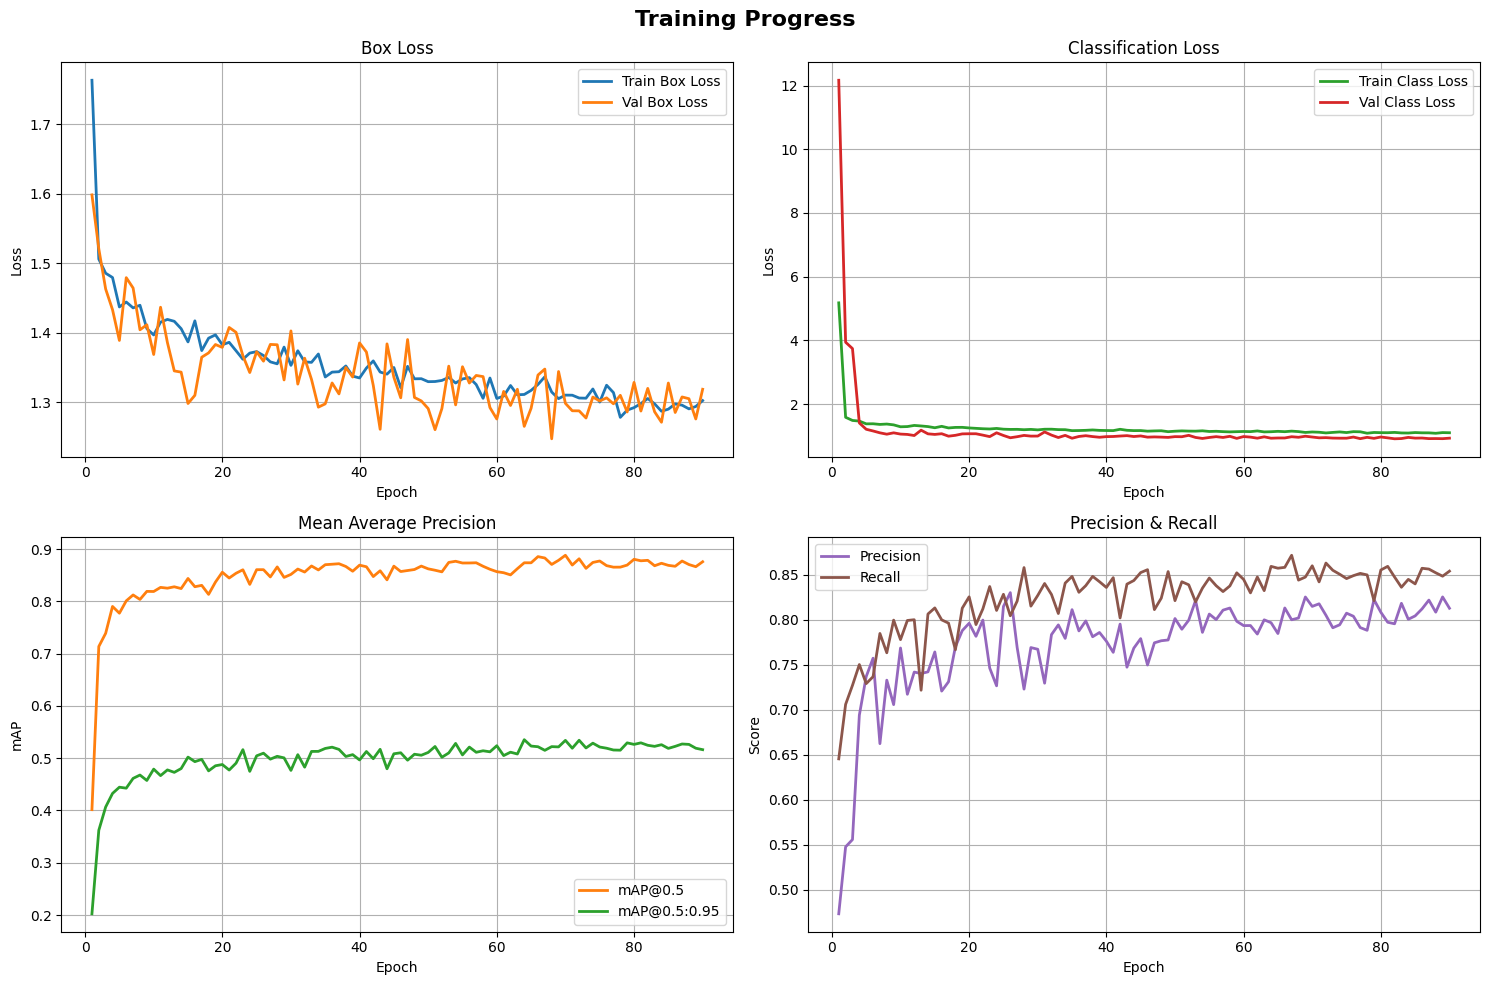

In [ ]:
# Plot training curves
evaluator.plot_training_curves(f'yolo_experiments/{yolo}_training')

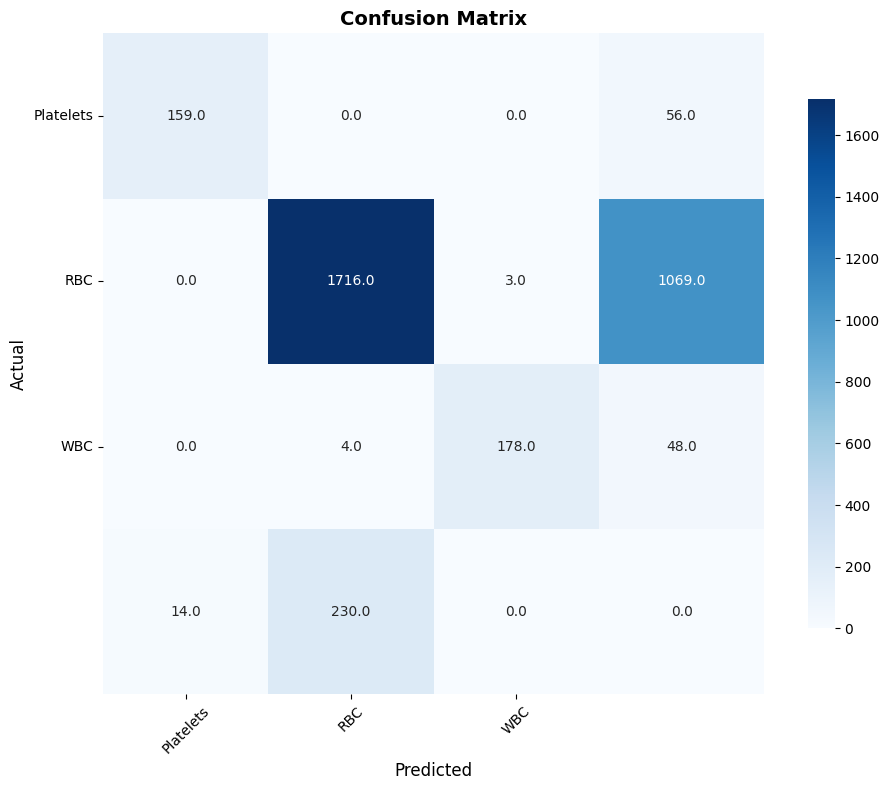

📊 Per-Class Performance:
       Class  AP@0.5  AP@0.5:0.95  Precision  Recall
0  Platelets   0.882        0.463      0.864   0.843
1        RBC   0.801        0.521      0.727   0.775
2        WBC   0.977        0.683      0.877   0.978


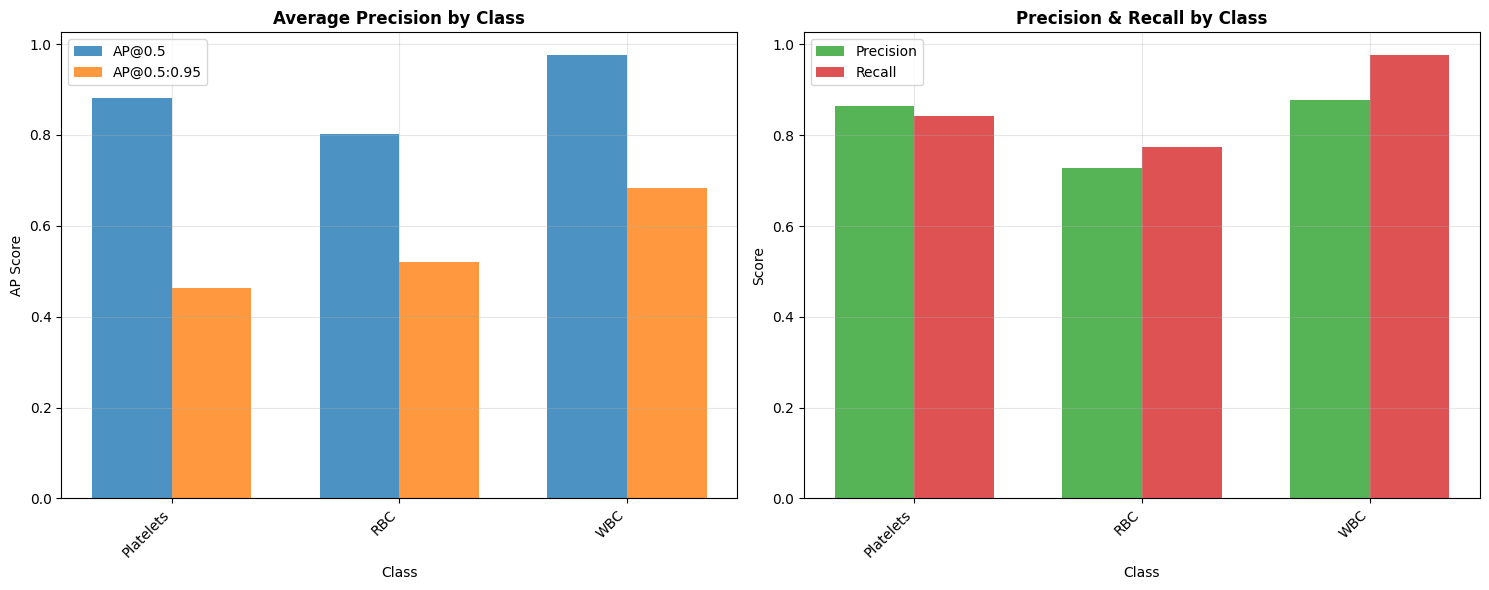

In [ ]:
# Analyze confusion matrix and class-wise performance
evaluator.confusion_matrix_analysis(eval_results)
class_performance = evaluator.class_wise_performance(eval_results)

In [41]:
class HyperparameterTuner:
    def __init__(self, base_model, dataset_path):
        self.base_model = base_model
        self.dataset_path = dataset_path
        self.best_params = None
        self.best_score = 0
        
    def tune_hyperparameters(self):
        """Tune hyperparameters using YOLO's built-in tuner"""
        
        print("🔧 Starting hyperparameter tuning...")
        
        # Use YOLO's built-in hyperparameter tuning
        tuner_results = self.base_model.tune(
            data=self.dataset_path,
            epochs=30,  # Reduced epochs for tuning
            iterations=100,  # Number of tuning iterations
            optimizer='AdamW',
            plots=True,
            save=True,
            val=True
        )
        
        return tuner_results
    
    def manual_grid_search(self):
        """Manual grid search for key hyperparameters"""
        
        param_grid = {
            'lr0': [0.001, 0.01, 0.1],
            'weight_decay': [0.0001, 0.0005, 0.001],
            'momentum': [0.9, 0.937, 0.95],
            'batch_size': [8, 16, 32]
        }
        
        best_score = 0
        best_params = {}
        results_log = []
        
        for lr in param_grid['lr0']:
            for wd in param_grid['weight_decay']:
                for mom in param_grid['momentum']:
                    for batch in param_grid['batch_size']:
                        
                        print(f"Testing: lr={lr}, wd={wd}, momentum={mom}, batch={batch}")
                        
                        # Train with current parameters
                        model = YOLO(f'yolov8n.pt')
                        
                        try:
                            results = model.train(
                                data=self.dataset_path,
                                epochs=20,  # Quick training for tuning
                                lr0=lr,
                                weight_decay=wd,
                                momentum=mom,
                                batch=batch,
                                patience=10,
                                save=False,
                                plots=False,
                                verbose=False
                            )
                            
                            # Get validation mAP
                            val_results = model.val(verbose=False)
                            score = val_results.box.map50
                            
                            results_log.append({
                                'lr0': lr,
                                'weight_decay': wd,
                                'momentum': mom,
                                'batch_size': batch,
                                'mAP50': score
                            })
                            
                            if score > best_score:
                                best_score = score
                                best_params = {
                                    'lr0': lr,
                                    'weight_decay': wd,
                                    'momentum': mom,
                                    'batch_size': batch
                                }
                                
                        except Exception as e:
                            print(f"Error with params: {e}")
                            continue
        
        # Create results DataFrame
        results_df = pd.DataFrame(results_log)
        
        print(f"\n🏆 Best parameters: {best_params}")
        print(f"🎯 Best mAP50: {best_score:.4f}")
        
        return best_params, results_df
    
    def visualize_tuning_results(self, results_df):
        """Visualize hyperparameter tuning results"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Hyperparameter Tuning Results', fontsize=16)
        
        # Learning rate vs mAP
        lr_groups = results_df.groupby('lr0')['mAP50'].mean()
        axes[0, 0].bar(lr_groups.index.astype(str), lr_groups.values)
        axes[0, 0].set_title('Learning Rate vs mAP50')
        axes[0, 0].set_xlabel('Learning Rate')
        axes[0, 0].set_ylabel('mAP50')
        
        # Weight decay vs mAP
        wd_groups = results_df.groupby('weight_decay')['mAP50'].mean()
        axes[0, 1].bar(wd_groups.index.astype(str), wd_groups.values)
        axes[0, 1].set_title('Weight Decay vs mAP50')
        axes[0, 1].set_xlabel('Weight Decay')
        axes[0, 1].set_ylabel('mAP50')
        
        # Momentum vs mAP
        mom_groups = results_df.groupby('momentum')['mAP50'].mean()
        axes[1, 0].bar(mom_groups.index.astype(str), mom_groups.values)
        axes[1, 0].set_title('Momentum vs mAP50')
        axes[1, 0].set_xlabel('Momentum')
        axes[1, 0].set_ylabel('mAP50')
        
        # Batch size vs mAP
        batch_groups = results_df.groupby('batch_size')['mAP50'].mean()
        axes[1, 1].bar(batch_groups.index.astype(str), batch_groups.values)
        axes[1, 1].set_title('Batch Size vs mAP50')
        axes[1, 1].set_xlabel('Batch Size')
        axes[1, 1].set_ylabel('mAP50')
        
        plt.tight_layout()
        plt.show()

In [42]:
# base_model = YOLO('yolov8n.pt')
# tuner = HyperparameterTuner(base_model, '../data/detection/data.yaml')

In [43]:
# # Option 1: Use YOLO's built-in tuning
# # tuning_results = tuner.tune_hyperparameters()

# # Option 2: Manual grid search (commented out as it takes time)
# best_params, tuning_df = tuner.manual_grid_search()
# tuner.visualize_tuning_results(tuning_df)

In [44]:
class YOLOInference:
    def __init__(self, model_path, conf_threshold=0.25, iou_threshold=0.45):
        self.model = YOLO(model_path)
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        
    def predict_single_image(self, image_path, save_results=True):
        """Predict on a single image"""
        
        results = self.model(
            image_path,
            conf=self.conf_threshold,
            iou=self.iou_threshold,
            save=save_results,
            show_labels=True,
            show_conf=True,
            device='cuda'
        )
        
        return results[0]
    
    def predict_batch(self, image_dir, output_dir='predictions'):
        """Predict on a batch of images"""
        
        image_paths = list(Path(image_dir).glob('*'))
        results = []
        
        for img_path in image_paths:
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                result = self.predict_single_image(img_path, save_results=False)
                results.append({
                    'image': img_path.name,
                    'detections': len(result.boxes) if result.boxes else 0,
                    'result': result
                })
        
        return results
    
    def annotate_image(self, image_path, output_path=None):
        """Annotate image with predictions"""
        
        # Load image
        image = cv2.imread(str(image_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get predictions
        results = self.model(image_path, conf=self.conf_threshold, iou=self.iou_threshold)
        
        # Annotate image
        annotated_image = results[0].plot()
        
        if output_path:
            cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
        
        return annotated_image
    
    def benchmark_performance(self, test_images, iterations=10):
        """Benchmark inference performance"""
        
        import time
        
        times = []
        
        for i in range(iterations):
            start_time = time.time()
            
            for img_path in test_images[:10]:  # Test on first 10 images
                _ = self.model(img_path, conf=self.conf_threshold, verbose=False)
            
            end_time = time.time()
            times.append(end_time - start_time)
        
        avg_time = np.mean(times)
        fps = len(test_images[:10]) / avg_time
        
        print(f"⚡ Performance Benchmark:")
        print(f"Average time per batch: {avg_time:.4f} seconds")
        print(f"FPS: {fps:.2f}")
        print(f"Average time per image: {avg_time/len(test_images[:10]):.4f} seconds")
        
        return {'avg_time': avg_time, 'fps': fps}
    
    def export_model(self, format='onnx'):
        """Export model to different formats"""
        
        print(f"📤 Exporting model to {format} format...")
        
        try:
            self.model.export(format=format, imgsz=640, half=False, int8=False)
            print(f"✅ Model exported successfully to {format}")
        except Exception as e:
            print(f"❌ Export failed: {e}")

In [45]:
# Initialize inference engine
inference = YOLOInference(f'yolo_experiments/{yolo}_training/weights/best.pt')


In [ ]:
# Test inference on sample images
sample_images = list(Path('../data/detection/test/images').glob('*.jpg'))[:5] 
if sample_images:
    # Single image prediction
    result = inference.predict_single_image(sample_images[0])
    print(f"Detected {len(result.boxes)} objects in {sample_images[0].name}")
    
    # Batch prediction
    batch_results = inference.predict_batch('../data/detection/test/images') 
    print(f"Processed {len(batch_results)} images")
    
    # Performance benchmark
    performance = inference.benchmark_performance(sample_images)
    
    # Export model
    inference.export_model('onnx')


image 1/1 c:\YOLOv8-Medical-Imaging\detection\..\data\detection\test\images\BloodImage_00000_jpg.rf.3c989e091c9a8d2e00ac1ec830f58830.jpg: 640x640 20 RBCs, 1 WBC, 27.0ms
Speed: 5.5ms preprocess, 27.0ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict2
Detected 21 objects in BloodImage_00000_jpg.rf.3c989e091c9a8d2e00ac1ec830f58830.jpg

image 1/1 c:\YOLOv8-Medical-Imaging\detection\..\data\detection\test\images\BloodImage_00000_jpg.rf.3c989e091c9a8d2e00ac1ec830f58830.jpg: 640x640 20 RBCs, 1 WBC, 27.2ms
Speed: 3.0ms preprocess, 27.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\YOLOv8-Medical-Imaging\detection\..\data\detection\test\images\BloodImage_00003_jpg.rf.dae8a5b9c14d73de9341ae5777fc876b.jpg: 640x640 1 Platelets, 14 RBCs, 1 WBC, 26.6ms
Speed: 3.2ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\YOLOv8-Medical-Imaging\detection\..\data\detection

In [47]:
class AdvancedMetrics:
    def __init__(self, model_path, dataset_path):
        self.model = YOLO(model_path)
        self.dataset_path = dataset_path
        
    def calculate_detailed_metrics(self, test_split='test'):
        """Calculate detailed evaluation metrics"""
        
        # Run validation
        val_results = self.model.val(
            data=self.dataset_path,
            split=test_split,
            conf=0.001,
            iou=0.6,
            plots=True,
            save_json=True
        )

        # Initialize metrics dictionary
        metrics_dict = {
            'Overall Metrics': {
                'mAP@0.5': val_results.box.map50,
                'mAP@0.5:0.95': val_results.box.map,
                'mAP@0.75': val_results.box.map75,
                'Precision': val_results.box.mp,
                'Recall': val_results.box.mr,
                'F1-Score': 2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr + 1e-16)
            }
        }

        # Compute IoU if possible
        tp = val_results.box.tp if hasattr(val_results.box, 'tp') else None
        fp = val_results.box.fp if hasattr(val_results.box, 'fp') else None
        fn = val_results.box.fn if hasattr(val_results.box, 'fn') else None

        if tp is not None and fp is not None and fn is not None:
            iou = tp / (tp + fp + fn + 1e-16)
            metrics_dict['Overall Metrics']['IoU'] = iou

        # Per-class metrics
        if hasattr(val_results.box, 'ap_class_index'):
            class_names = [val_results.names[i] for i in val_results.box.ap_class_index]
            metrics_dict['Per-Class Metrics'] = {}

            for i, class_name in enumerate(class_names):
                metrics_dict['Per-Class Metrics'][class_name] = {
                    'AP@0.5': val_results.box.ap50[i],
                    'AP@0.5:0.95': val_results.box.ap[i],
                    'Precision': val_results.box.p[i],
                    'Recall': val_results.box.r[i],
                    'IoU': val_results.box.tp[i] / (val_results.box.tp[i] + val_results.box.fp[i] + val_results.box.fn[i] + 1e-16)
                        if all(hasattr(val_results.box, attr) for attr in ['tp', 'fp', 'fn']) else None
                }

        return metrics_dict, val_results

    
    
    
    def _create_basic_performance_plot(self, val_results):
        """Create basic performance visualization when curves are not available"""
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Overall metrics bar chart
        metrics = {}
        if hasattr(val_results.box, 'map50'):
            metrics['mAP@0.5'] = val_results.box.map50
        if hasattr(val_results.box, 'map'):
            metrics['mAP@0.5:0.95'] = val_results.box.map
        if hasattr(val_results.box, 'mp'):
            metrics['Precision'] = val_results.box.mp
        if hasattr(val_results.box, 'mr'):
            metrics['Recall'] = val_results.box.mr
        
        if metrics:
            metric_names = list(metrics.keys())
            metric_values = list(metrics.values())
            
            bars = axes[0].bar(metric_names, metric_values, alpha=0.7, color=['blue', 'green', 'orange', 'red'])
            axes[0].set_ylabel('Score')
            axes[0].set_title('Overall Performance Metrics')
            axes[0].set_ylim([0, 1])
            axes[0].grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars, metric_values):
                axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom')
        
        # Plot 2: Class-wise AP if available
        if hasattr(val_results.box, 'ap50') and val_results.box.ap50 is not None:
            ap_scores = val_results.box.ap50
            
            if not np.isscalar(ap_scores):
                class_indices = range(len(ap_scores))
                bars = axes[1].bar(class_indices, ap_scores, alpha=0.7)
                axes[1].set_xlabel('Class Index')
                axes[1].set_ylabel('AP@0.5')
                axes[1].set_title('Average Precision per Class')
                axes[1].grid(True, alpha=0.3)
                
                # Add value labels
                for bar, value in zip(bars, ap_scores):
                    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{value:.2f}', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    def error_analysis(self, val_results):
        """Perform error analysis"""
        
        print("🔍 Error Analysis:")
        print(f"Available val_results attributes: {[attr for attr in dir(val_results) if not attr.startswith('_')]}")
        
        # Method 1: Try to get stats from different locations
        stats = None
        
        if hasattr(val_results, 'box'):
            print(f"Box attributes: {[attr for attr in dir(val_results.box) if not attr.startswith('_')]}")
            
            # Check for confusion matrix or stats
            if hasattr(val_results.box, 'confusion_matrix') and val_results.box.confusion_matrix is not None:
                cm = val_results.box.confusion_matrix
                print(f"Confusion matrix shape: {cm.shape if hasattr(cm, 'shape') else 'No shape'}")
                
                # Calculate TP, FP, FN from confusion matrix
                if hasattr(cm, 'matrix'):
                    matrix = cm.matrix
                    tp = np.diag(matrix).sum()
                    fp = matrix.sum(axis=0) - np.diag(matrix)
                    fn = matrix.sum(axis=1) - np.diag(matrix)
                    
                    fp_total = fp.sum()
                    fn_total = fn.sum()
                    
                    stats = [tp, fp_total, fn_total]
                    print(f"From confusion matrix - TP: {tp}, FP: {fp_total}, FN: {fn_total}")
            
            # Try to calculate from precision and recall
            elif hasattr(val_results.box, 'mp') and hasattr(val_results.box, 'mr'):
                precision = val_results.box.mp
                recall = val_results.box.mr
                
                if precision is not None and recall is not None:
                    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
                    
                    # For visualization, we'll use normalized values
                    # These aren't actual counts but show relative performance
                    stats = [recall, 1-precision, 1-recall]  # Approximation for visualization
        
        # Method 2: Check if stats exist directly
        if hasattr(val_results, 'stats') and val_results.stats is not None:
            stats = val_results.stats
            print(f"Found direct stats: {stats}")
        
        # Display results
        if stats is not None and len(stats) >= 3:
            tp, fp, fn = stats[0], stats[1], stats[2]
            
            print(f"True Positives: {tp}")
            print(f"False Positives: {fp}")
            print(f"False Negatives: {fn}")
            
            # Calculate additional metrics
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-16)
            
            print(f"Calculated Precision: {precision:.4f}")
            print(f"Calculated Recall: {recall:.4f}")
            print(f"Calculated F1-Score: {f1:.4f}")
            
            # Visualize error distribution
            categories = ['True Positives', 'False Positives', 'False Negatives']
            values = [tp, fp, fn]
            
            plt.figure(figsize=(10, 6))
            bars = plt.bar(categories, values, color=['green', 'orange', 'red'], alpha=0.7)
            plt.title('Detection Error Analysis')
            plt.ylabel('Count')
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                        f'{value:.2f}', ha='center', va='bottom')
            
            plt.grid(True, alpha=0.3)
            plt.show()
            
        else:
            print("❌ No statistical data found for error analysis.")
            
            # Create alternative analysis using available metrics
            self._create_alternative_error_analysis(val_results)

        
    def create_evaluation_report(self, metrics_dict, save_path='evaluation_report.txt'):
        """Create comprehensive evaluation report"""

        report = []
        report.append("=" * 60)
        report.append("YOLOV8 MODEL EVALUATION REPORT")
        report.append("=" * 60)
        report.append(f"Generated on: {pd.Timestamp.now()}")
        report.append("")

        # Overall metrics
        report.append("📊 OVERALL PERFORMANCE METRICS")
        report.append("-" * 40)
        for metric, value in metrics_dict['Overall Metrics'].items():
            if isinstance(value, (int, float)):
                report.append(f"{metric:20}: {value:.4f}")
            elif value is None:
                report.append(f"{metric:20}: N/A")
            else:
                report.append(f"{metric:20}: {str(value)}")
        report.append("")

        # Per-class metrics
        if 'Per-Class Metrics' in metrics_dict:
            report.append("🏷️ PER-CLASS PERFORMANCE METRICS")
            report.append("-" * 40)
            for class_name, class_metrics in metrics_dict['Per-Class Metrics'].items():
                report.append(f"\n{class_name}:")
                for metric, value in class_metrics.items():
                    if isinstance(value, (int, float)):
                        report.append(f"  {metric:15}: {value:.4f}")
                    elif value is None:
                        report.append(f"  {metric:15}: N/A")
                    else:
                        report.append(f"  {metric:15}: {str(value)}")

        # Model recommendations
        report.append("\n🎯 RECOMMENDATIONS")
        report.append("-" * 40)

        overall_map = metrics_dict['Overall Metrics'].get('mAP@0.5:0.95', None)
        if isinstance(overall_map, (int, float)):
            if overall_map > 0.7:
                report.append("✅ Excellent performance! Model is ready for deployment.")
            elif overall_map > 0.5:
                report.append("✅ Good performance. Consider fine-tuning for better results.")
            elif overall_map > 0.3:
                report.append("⚠️ Moderate performance. More training data or model tuning needed.")
            else:
                report.append("❌ Poor performance. Significant improvements needed.")
        else:
            report.append("❓ Unable to determine performance — invalid or missing mAP value.")

        report.append("")
        report.append("=" * 60)

        # Save report
        with open(save_path, 'w') as f:
            f.write('\n'.join(report))

        print('\n'.join(report))
        print(f"\n📄 Report saved to: {save_path}")


In [ ]:
# Advanced metrics analysis
metrics_analyzer = AdvancedMetrics(f'yolo_experiments/{yolo}_training/weights/best.pt', '../data/detection/data.yaml')
detailed_metrics, val_results = metrics_analyzer.calculate_detailed_metrics()


Ultralytics 8.3.152  Python-3.10.18 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 108.944.9 MB/s, size: 13.7 KB)


val: Scanning C:\YOLOv8-Medical-Imaging\data\detection\test\labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


                   all         87       1140       0.79      0.844      0.876      0.529
             Platelets         36         50      0.803       0.78      0.829      0.394
                   RBC         84        995      0.708      0.776      0.823      0.507
                   WBC         86         95      0.861      0.975      0.975      0.686
Speed: 2.7ms preprocess, 27.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving runs\detect\val4\predictions.json...
Results saved to runs\detect\val4


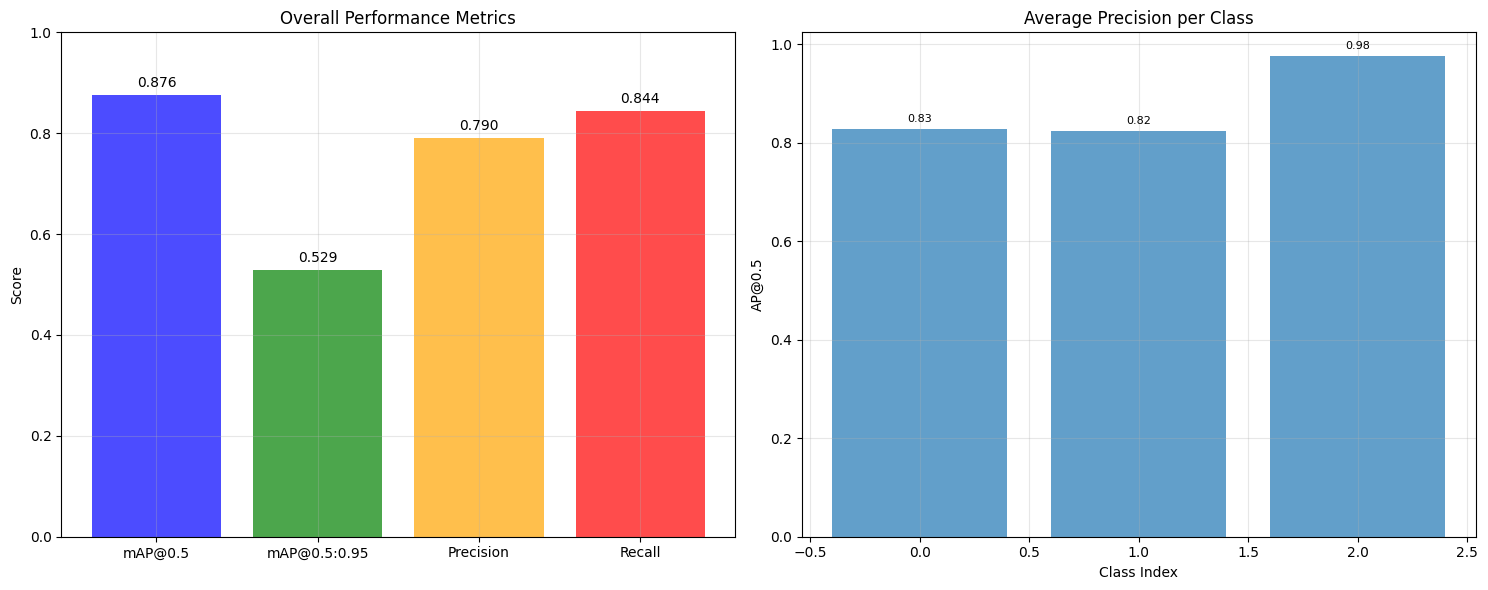

In [ ]:
# Plot PR curves
metrics_analyzer._create_basic_performance_plot(val_results)


🔍 Error Analysis:
Available val_results attributes: ['ap_class_index', 'box', 'class_result', 'confusion_matrix', 'curves', 'curves_results', 'fitness', 'keys', 'maps', 'mean_results', 'names', 'plot', 'process', 'results_dict', 'save_dir', 'speed', 'summary', 'task', 'to_csv', 'to_df', 'to_html', 'to_json', 'to_sql', 'to_xml', 'tojson']
Box attributes: ['all_ap', 'ap', 'ap50', 'ap_class_index', 'class_result', 'curves', 'curves_results', 'f1', 'f1_curve', 'fitness', 'map', 'map50', 'map75', 'maps', 'mean_results', 'mp', 'mr', 'nc', 'p', 'p_curve', 'prec_values', 'px', 'r', 'r_curve', 'update']
Precision: 0.7904, Recall: 0.8438
True Positives: 0.8437611466325946
False Positives: 0.2096349862267507
False Negatives: 0.1562388533674054
Calculated Precision: 0.8010
Calculated Recall: 0.8438
Calculated F1-Score: 0.8218


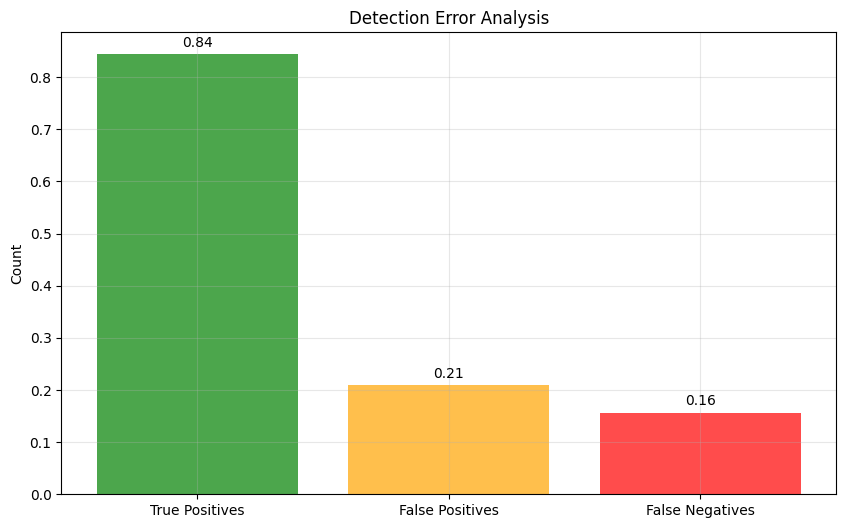

In [ ]:

# Error analysis
metrics_analyzer.error_analysis(val_results)


In [51]:
# Create evaluation report
metrics_analyzer.create_evaluation_report(detailed_metrics)

YOLOV8 MODEL EVALUATION REPORT
Generated on: 2025-06-17 21:22:21.429309

📊 OVERALL PERFORMANCE METRICS
----------------------------------------
mAP@0.5             : 0.8758
mAP@0.5:0.95        : 0.5291
mAP@0.75            : 0.5588
Precision           : 0.7904
Recall              : 0.8438
F1-Score            : 0.8162

🏷️ PER-CLASS PERFORMANCE METRICS
----------------------------------------

Platelets:
  AP@0.5         : 0.8286
  AP@0.5:0.95    : 0.3942
  Precision      : 0.8028
  Recall         : 0.7800
  IoU            : N/A

RBC:
  AP@0.5         : 0.8235
  AP@0.5:0.95    : 0.5070
  Precision      : 0.7076
  Recall         : 0.7759
  IoU            : N/A

WBC:
  AP@0.5         : 0.9753
  AP@0.5:0.95    : 0.6861
  Precision      : 0.8607
  Recall         : 0.9754
  IoU            : N/A

🎯 RECOMMENDATIONS
----------------------------------------
✅ Good performance. Consider fine-tuning for better results.


📄 Report saved to: evaluation_report.txt


In [52]:
class ModelComparison:
    def __init__(self, model_paths, dataset_path):
        self.models = {f'Model_{i+1}': YOLO(path) for i, path in enumerate(model_paths)}
        self.dataset_path = dataset_path
        self.comparison_results = {}
        
    def compare_models(self):
        """Compare multiple models"""
        
        print("🔄 Comparing models...")
        
        for model_name, model in self.models.items():
            print(f"Evaluating {model_name}...")
            
            val_results = model.val(
                data=self.dataset_path,
                split='test',
                conf=0.25,
                iou=0.6,
                verbose=False
            )
            
            self.comparison_results[model_name] = {
                'mAP@0.5': val_results.box.map50,
                'mAP@0.5:0.95': val_results.box.map,
                'Precision': val_results.box.mp,
                'Recall': val_results.box.mr,
                'F1-Score': 2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr + 1e-16)
            }
        
        return self.comparison_results
    
    def visualize_comparison(self):
        """Visualize model comparison"""
        
        df_comparison = pd.DataFrame(self.comparison_results).T
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
        
        metrics = ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall']
        
        for i, metric in enumerate(metrics):
            ax = axes[i//2, i%2]
            df_comparison[metric].plot(kind='bar', ax=ax, color='skyblue', alpha=0.8)
            ax.set_title(f'{metric} Comparison')
            ax.set_ylabel(metric)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for j, v in enumerate(df_comparison[metric]):
                ax.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison table
        print("\n📊 Model Comparison Results:")
        print(df_comparison.round(4))
        
        # Rank models
        df_comparison['Overall_Score'] = (df_comparison['mAP@0.5:0.95'] + 
                                        df_comparison['Precision'] + 
                                        df_comparison['Recall']) / 3
        
        ranked_models = df_comparison.sort_values('Overall_Score', ascending=False)
        print(f"\n🏆 Best performing model: {ranked_models.index[0]}")
        
        return df_comparison

class EnsemblePredictor:
    def __init__(self, model_paths, weights=None):
        self.models = [YOLO(path) for path in model_paths]
        self.weights = weights or [1.0] * len(model_paths)
        
    def ensemble_predict(self, image_path, conf_threshold=0.25):
        """Ensemble prediction using multiple models"""
        
        all_predictions = []
        
        # Get predictions from all models
        for i, model in enumerate(self.models):
            results = model(image_path, conf=conf_threshold, verbose=False)
            if results[0].boxes is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                scores = results[0].boxes.conf.cpu().numpy()
                classes = results[0].boxes.cls.cpu().numpy()
                
                # Weight the scores
                weighted_scores = scores * self.weights[i]
                
                for box, score, cls in zip(boxes, weighted_scores, classes):
                    all_predictions.append({
                        'box': box,
                        'score': score,
                        'class': cls,
                        'model': i
                    })
        
        # Apply Non-Maximum Suppression to ensemble results
        if all_predictions:
            ensemble_boxes = np.array([pred['box'] for pred in all_predictions])
            ensemble_scores = np.array([pred['score'] for pred in all_predictions])
            ensemble_classes = np.array([pred['class'] for pred in all_predictions])
            
            # Simple NMS implementation (you might want to use a more sophisticated one)
            keep_indices = self._nms(ensemble_boxes, ensemble_scores, iou_threshold=0.5)
            
            final_predictions = {
                'boxes': ensemble_boxes[keep_indices],
                'scores': ensemble_scores[keep_indices],
                'classes': ensemble_classes[keep_indices]
            }
            
            return final_predictions
        
        return {'boxes': [], 'scores': [], 'classes': []}
    
    def _nms(self, boxes, scores, iou_threshold=0.5):
        """Non-Maximum Suppression"""
        if len(boxes) == 0:
            return []
        
        # Convert to [x1, y1, x2, y2] format if needed
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        
        areas = (x2 - x1) * (y2 - y1)
        order = scores.argsort()[::-1]
        
        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])
            
            w = np.maximum(0.0, xx2 - xx1)
            h = np.maximum(0.0, yy2 - yy1)
            intersection = w * h
            
            iou = intersection / (areas[i] + areas[order[1:]] - intersection)
            
            inds = np.where(iou <= iou_threshold)[0]
            order = order[inds + 1]
        
        return keep

In [53]:

# Example usage (uncomment to use)
# model_paths = [
#     'yolo_experiments/yolov8n_training/weights/best.pt',
#     'yolo_experiments/yolov8s_training/weights/best.pt',
#     'yolo_experiments/yolov8m_training/weights/best.pt'
# ]

# Model comparison
# comparator = ModelComparison(model_paths, 'data.yaml')
# comparison_results = comparator.compare_models()
# comparison_df = comparator.visualize_comparison()

# Ensemble prediction
# ensemble = EnsemblePredictor(model_paths, weights=[0.4, 0.4, 0.2])
# ensemble_result = ensemble.ensemble_predict('path/to/test/image.jpg')